In [1]:
import scanpy as sc
#from cellbender.remove_background.downstream import anndata_from_h5
import pandas as pd
import numpy as np
import scipy.sparse
import scipy.cluster.hierarchy as shc
from scipy import stats
from scipy.sparse import csr_matrix, hstack
import os
import anndata
import time
import SEACells
from matplotlib.colors import LinearSegmentedColormap

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif' 

np.random.seed(1966)


# Non redundant peakset

In [2]:
devScores = pd.read_csv("../intermediate_outputs3/chromvar/non_redundant_deviationScores.csv", index_col = 0)
devScores

,SEACell-0-0,SEACell-1-0,SEACell-2-0,SEACell-3-0,SEACell-4-0,SEACell-5-0,SEACell-6-0,SEACell-7-0,SEACell-8-0,SEACell-9-0,...,SEACell-61-1,SEACell-62-1,SEACell-63-1,SEACell-64-1,SEACell-65-1,SEACell-66-1,SEACell-67-1,SEACell-68-1,SEACell-69-1,SEACell-70-1
ENSMUSG00000021359_LINE1_Tcfap2a_D_N1,-6.004726,-3.830048,1.101656,-0.620217,-0.644929,-1.778687,0.188579,0.876798,0.797529,-3.101942,...,4.027039,1.800174,2.958021,1.147995,-5.872732,1.321281,-6.650630,-0.568128,1.404672,4.351728
ENSMUSG00000025927_LINE5_Tcfap2b_D,-5.292302,-1.528906,0.387824,-0.786302,-2.249377,-1.132487,-0.885163,1.338665,2.373598,-2.149541,...,5.737401,0.789224,2.026435,2.779032,-6.413560,0.070932,-7.247328,-1.070735,1.026502,4.042402
ENSMUSG00000028640_LINE6_Tcfap2c_D,-4.464326,-2.991793,1.213786,-0.293006,-1.855988,-0.249675,0.115281,1.210791,0.717155,-2.195114,...,3.183757,1.932747,3.107949,-0.094483,-5.795971,0.841998,-5.953868,-0.288818,1.824432,4.498630
ENSMUSG00000042477_LINE7_Tcfap2e_D,-4.435583,-2.403158,-0.260493,-1.174822,-2.213792,-0.555501,-1.158778,1.453399,2.440061,-3.333122,...,6.356178,0.598768,2.458572,2.874655,-4.808436,1.093710,-5.270280,-1.511718,0.589653,4.224162
ENSMUSG00000042596_LINE8_Tcfap2d_I,-2.952409,-2.429481,-0.243265,1.603105,-1.273440,-0.779293,1.562352,0.417376,0.482207,0.249403,...,0.182042,0.136101,2.829911,0.061044,-0.017496,2.591049,-1.428491,2.382201,-0.147763,0.966615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000001517_LINE5830_Foxm1_I_N1,-0.677156,-1.358051,1.135354,6.679362,-0.425015,-0.351420,1.357930,1.689156,7.333011,0.692394,...,1.056372,-6.941447,1.748152,2.169651,2.264803,6.281850,-2.479635,-2.948881,0.884345,-3.737351
ENSMUSG00000026497_LINE12141_Mixl1_I,-0.612390,-1.794840,3.288228,3.658685,-0.406485,-0.981006,3.424986,-0.154583,3.543397,0.659931,...,2.560331,-1.250618,0.973129,0.379939,0.765957,2.748315,-0.138020,0.731969,0.483372,0.694971
ENSMUSG00000079033_LINE16135_Mef2b_I_N14,-1.664771,-0.508613,-1.452821,-2.846063,4.419237,2.716817,-1.704075,3.426223,-1.922827,-0.230535,...,1.534774,-2.572624,-3.172369,5.464173,-0.583530,-2.637569,-3.769528,-2.754067,-1.374572,-3.727140
ENSMUSG00000021540_LINE17865_Smad5_I_N1,0.262620,-1.564501,-0.052672,1.597977,1.026638,-0.263518,0.059541,-0.403946,-0.487712,1.378774,...,-0.373184,0.923107,2.499937,-0.949891,3.461907,-0.219170,1.651437,2.314395,1.972507,-0.568963


In [3]:
ad = sc.AnnData(devScores.T)
ad.obs_names = ad.obs_names.astype(str)

In [4]:
def procesar_strings(lista_strings):
    resultado = []
    for s in lista_strings:
        partes = s.split('_')
        if len(partes) >= 5:
            resultado.append('_'.join(partes[-3:]))
        elif len(partes) == 4:
            resultado.append('_'.join(partes[-2:]))
        else:
            resultado.append(s)  # Si no tiene 4 o 5 elementos, lo dejamos igual
    return resultado

In [5]:
ad.var_names = procesar_strings(list(ad.var_names))


In [6]:
ad_norm_obs = pd.read_csv("../intermediate_outputs3/DESeq2_files/metadata_scpeakset_D30.tsv", sep = '\t')
ad.obs = ad_norm_obs

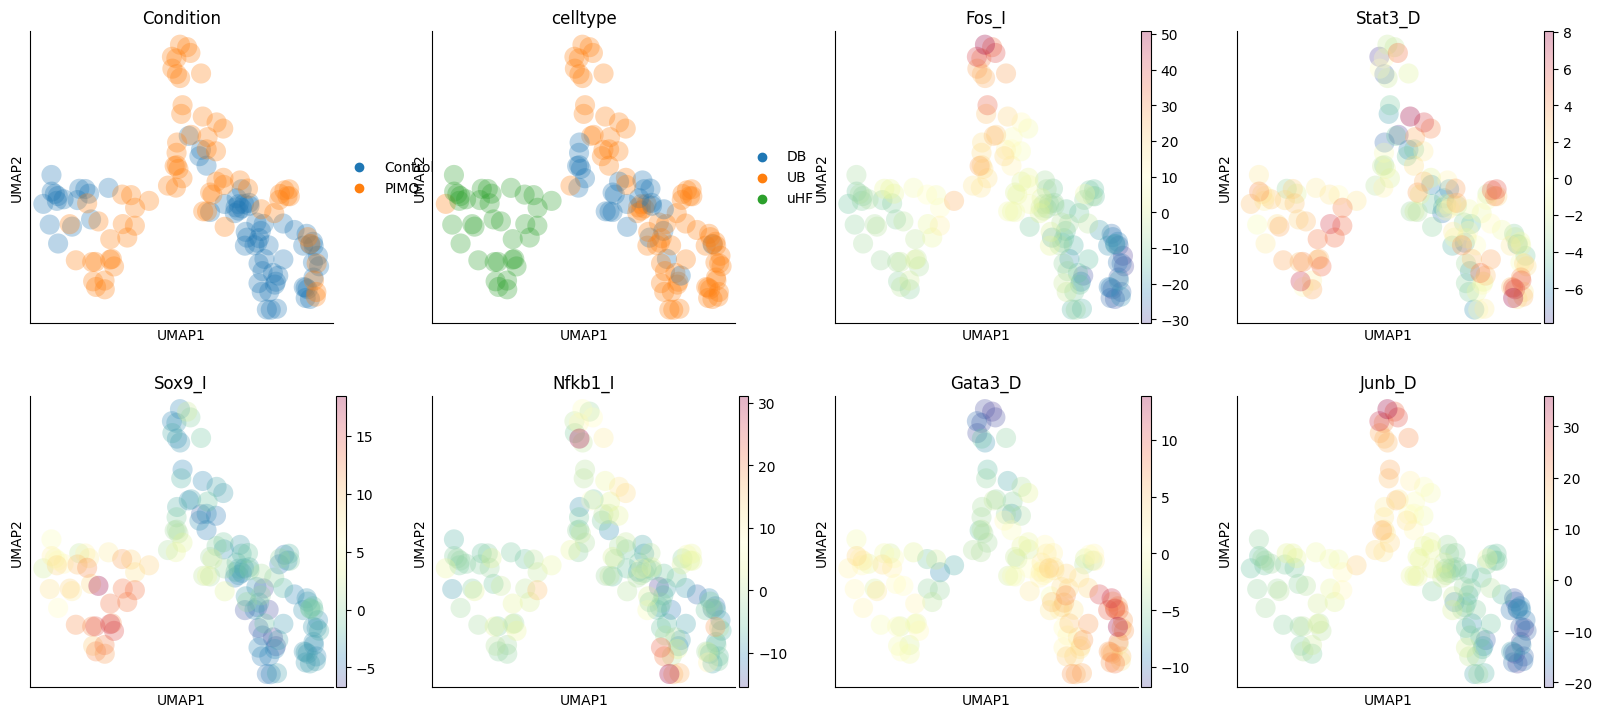

In [7]:
sc.pp.pca(ad, n_comps = 50)
sc.pp.neighbors(ad, n_neighbors = 5)
sc.tl.umap(ad, n_components = 50)
sc.pl.umap(ad, color = ['Condition', 'celltype', 'Fos_I', 'Stat3_D', 'Sox9_I', 'Nfkb1_I', 'Gata3_D', 'Junb_D'], alpha = 0.3)
#sc.pl.umap(ad[ad.obs['Condition'] == 'PIMQ'], color = ['Condition', 'celltype', 'Fos_I', 'Stat3_D', 'Sox9_I', 'Nfkb1_I'])

In [8]:
score_df = ad.to_df().copy()
score_df['condition_celltype'] = ad.obs['condition_celltype']

result = score_df.groupby('condition_celltype').mean().T
result['celltype'] = result.index
result['X'] = result['PIMQ_UB'] - result['Control_UB']
result['Y'] = result['PIMQ_DB'] - result['Control_DB']

result[result['celltype'].str.contains('Fos')]

condition_celltype,Control_DB,Control_UB,Control_uHF,PIMQ_DB,PIMQ_UB,PIMQ_uHF,celltype,X,Y
Fosb_I,-7.699724,-7.998783,-4.169101,5.694454,5.111309,-0.666810,Fosb_I,13.110091,13.394178
Fos_I,-10.607091,-11.457690,-5.177920,6.545594,8.126495,0.018506,Fos_I,19.584184,17.152686
Fosl1_D,-6.114186,-5.587981,-2.772247,2.683884,3.966445,0.134833,Fosl1_D,9.554426,8.798069
Fosl2_D,-0.923689,-0.950152,-0.553748,1.125339,0.393327,0.720412,Fosl2_D,1.343479,2.049028


In [9]:
import plotly.express as px

result['color'] = ['red' if celltype in ['Junb_D', 'Gata3_D', 'Fosb_I', 'Stat3_D'] else 'blue' for celltype in result['celltype']]

fig = px.scatter(result, x="X", y="Y", 
                 color='color',
                 hover_name="celltype", 
                 labels={"X": "Diff (PIMQ_UB - Control_UB)", "Y": "Diff (PIMQ_DB - Control_DB)"},
                 hover_data=['celltype',"Control_UB", "PIMQ_UB", 'Control_DB', 'PIMQ_DB'])

fig.update_traces(marker=dict(size=8),
                  selector=dict(mode='markers'))

fig.update_layout(
    legend_title_text='Celltype',
    legend=dict(
        itemsizing='constant',
        itemwidth=30
    )
)

fig.data[0].name = 'All TFs'
fig.data[1].name = 'Highlighted TFs'

# Guardar como HTML interactivo
fig.write_html("scatter_plot.html")

print("Archivo guardado como scatter_plot.html")


Archivo guardado como scatter_plot.html


# Year 1 and Day 30

In [2]:
def procesar_strings(lista_strings):
    resultado = []
    for s in lista_strings:
        partes = s.split('_')
        if len(partes) >= 5:
            resultado.append('_'.join(partes[-3:]))
        elif len(partes) == 4:
            resultado.append('_'.join(partes[-2:]))
        else:
            resultado.append(s)  # Si no tiene 4 o 5 elementos, lo dejamos igual
    return resultado

In [3]:
devScores = pd.read_csv("../intermediate_outputs3/chromvar/non_redundant_deviationScores.csv", index_col = 0)

ad = sc.AnnData(devScores.T)
ad.obs_names = ad.obs_names.astype(str)
ad.var_names = procesar_strings(list(ad.var_names))

ad_norm_obs = pd.read_csv("../intermediate_outputs3/DESeq2_files/metadata_scpeakset_D30.tsv", sep = '\t')
ad.obs = ad_norm_obs

score_df = ad.to_df().copy()
score_df['condition_celltype'] = ad.obs['condition_celltype']
result = score_df.groupby('condition_celltype').mean().T
result['celltype'] = result.index
result['X'] = result['PIMQ_UB'] - result['Control_UB']
result['Y'] = result['PIMQ_DB'] - result['Control_DB']

In [4]:
score_df

,Tcfap2a_D_N1,Tcfap2b_D,Tcfap2c_D,Tcfap2e_D,Tcfap2d_I,Arid3b_D,Arid3a_D_N3,Arid5b_D,Arid5a_D,Arid3c_I,...,Zfp263_I_N2,Zfp263_I_N1,Zfp263_I_N1,Dmrta2_I_N3,Foxm1_I_N1,Mixl1_I,Mef2b_I_N14,Smad5_I_N1,Smad9_I_N1,condition_celltype
0,-6.004726,-5.292302,-4.464326,-4.435583,-2.952409,-0.118860,0.117804,-0.733228,-1.134206,1.124412,...,-0.882011,0.366970,-1.573080,0.022814,-0.677156,-0.612390,-1.664771,0.262620,-0.769553,Control_DB
1,-3.830048,-1.528906,-2.991793,-2.403158,-2.429481,-3.014503,0.124597,-1.838830,-0.735472,0.465445,...,-1.451008,0.110607,-1.250234,-0.889399,-1.358051,-1.794840,-0.508613,-1.564501,-0.349482,Control_UB
2,1.101656,0.387824,1.213786,-0.260493,-0.243265,1.736879,2.022005,1.627733,0.329621,0.601479,...,-0.299141,-1.355179,-0.045196,-0.643832,1.135354,3.288228,-1.452821,-0.052672,-1.422229,Control_UB
3,-0.620217,-0.786302,-0.293006,-1.174822,1.603105,1.787923,1.776825,-0.041568,5.384034,3.086599,...,1.646459,1.621420,1.254610,3.217308,6.679362,3.658685,-2.846063,1.597977,2.450362,Control_uHF
4,-0.644929,-2.249377,-1.855988,-2.213792,-1.273440,-1.256904,1.721342,-1.053884,-0.504969,1.571867,...,-0.548907,0.636547,-0.778096,1.597669,-0.425015,-0.406485,4.419237,1.026638,0.106998,Control_UB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,1.321281,0.070932,0.841998,1.093710,2.591049,2.023911,0.632156,1.373182,4.216134,1.587034,...,1.653394,-0.819985,0.835802,1.279598,6.281850,2.748315,-2.637569,-0.219170,2.532253,PIMQ_uHF
139,-6.650630,-7.247328,-5.953868,-5.270280,-1.428491,-0.169287,-1.386591,0.317079,-1.543882,-0.270354,...,-0.169631,-0.703311,-1.091741,0.308276,-2.479635,-0.138020,-3.769528,1.651437,-1.370895,PIMQ_DB
140,-0.568128,-1.070735,-0.288818,-1.511718,2.382201,0.472698,-2.013071,-0.831272,-1.085480,-1.729757,...,1.293051,-0.582537,1.455187,-1.533480,-2.948881,0.731969,-2.754067,2.314395,-0.208036,PIMQ_UB
141,1.404672,1.026502,1.824432,0.589653,-0.147763,-1.354894,-3.135184,-2.732920,-1.535797,-1.563318,...,0.565940,-1.733037,1.927845,-0.738401,0.884345,0.483372,-1.374572,1.972507,-3.520488,PIMQ_UB


In [26]:
result[result.index == 'Pit1_I_N1']

condition_celltype,Control_DB,Control_UB,Control_uHF,PIMQ_DB,PIMQ_UB,PIMQ_uHF,celltype,X,Y
Pit1_I_N1,-1.626047,-2.121426,1.167113,-0.192966,0.351769,4.395866,Pit1_I_N1,2.473195,1.433081
Pit1_I_N1,-3.720693,-6.559113,-0.437071,2.556531,3.047562,7.829220,Pit1_I_N1,9.606674,6.277224
Pit1_I_N1,0.639096,0.008864,0.006124,0.115759,-0.785110,1.614999,Pit1_I_N1,-0.793973,-0.523337


In [5]:
devScores = pd.read_csv("../intermediate_outputs3/chromvar/Y1_non_redundant_deviationScores.csv", index_col = 0)

ad = sc.AnnData(devScores.T)
ad.obs_names = ad.obs_names.astype(str)
ad.var_names = procesar_strings(list(ad.var_names))

ad_norm_obs = pd.read_csv("../intermediate_outputs3/DESeq2_files/metadata_scpeakset_Y1.tsv", sep = '\t')
ad.obs = ad_norm_obs

score_df = ad.to_df().copy()
score_df['condition_celltype'] = ad.obs['condition_celltype']
result2 = score_df.groupby('condition_celltype').mean().T
result2['celltype'] = result.index
result2['X'] = result2['PIMQ_UB'] - result2['Control_UB']
result2['Y'] = result2['PIMQ_DB'] - result2['Control_DB']

In [6]:
score_df

,Tcfap2a_D_N1,Tcfap2b_D,Tcfap2c_D,Tcfap2e_D,Tcfap2d_I,Arid3b_D,Arid3a_D_N3,Arid5b_D,Arid5a_D,Arid3c_I,...,Zfp263_I_N2,Zfp263_I_N1,Zfp263_I_N1,Dmrta2_I_N3,Foxm1_I_N1,Mixl1_I,Mef2b_I_N14,Smad5_I_N1,Smad9_I_N1,condition_celltype
0,-3.446944,-2.493191,-2.583164,-2.028648,-1.994843,-2.645676,-4.444138,-2.188070,-3.469681,-3.828357,...,-2.386081,-0.816902,-2.187771,-3.059966,-5.766796,-1.375683,-3.264837,-4.188338,-5.364873,Control_UB
1,1.551708,1.037282,1.869427,0.749872,3.511333,8.144512,3.540062,1.569671,3.146361,5.149125,...,3.130063,1.809827,2.614706,1.102798,6.583980,3.488580,-1.238099,3.631266,2.572313,Control_uHF
2,-2.539819,-3.016080,-3.738765,-1.925479,-5.905424,-2.808081,-3.727886,-1.352145,-1.889071,-4.407084,...,-5.805726,-1.726052,-5.833117,-4.599323,-3.291410,-3.334202,-4.272509,-5.620449,-2.981211,Control_UB
3,5.008739,6.334908,4.566052,5.602808,1.193193,-1.983472,-0.832336,-0.750996,-0.306271,-0.263955,...,-2.871421,-1.040888,-2.124006,0.088080,1.454913,-1.184039,0.011802,0.518556,-1.086803,Control_UB
4,0.794707,-0.593524,2.242104,-0.293120,5.653430,-0.801436,3.331877,-1.631623,2.081876,4.201885,...,0.755334,0.030172,-0.937666,0.998593,5.294017,0.561208,0.628418,6.970196,-2.736736,Control_UB
5,-2.994347,-0.437550,-1.815577,-2.100165,-1.007898,-0.293082,-1.068058,3.000941,-0.344813,0.064608,...,-2.478476,-0.748014,-2.054440,0.140603,2.981543,-1.299245,-2.254595,-1.024726,2.596002,Control_DB
6,4.585482,9.133179,4.876785,7.352036,0.238758,2.602363,0.790357,2.051220,2.032269,0.472141,...,-0.612215,-0.398180,-0.167347,2.223952,5.115341,1.253575,6.446175,-5.111845,2.422876,Control_DB
7,-2.074149,-1.134226,-1.505362,-1.466470,1.218445,0.531815,-0.310622,0.153281,-1.438380,-0.252221,...,3.249273,0.340674,2.752227,-0.342655,-5.736467,0.712213,0.788185,0.934183,-0.073845,Control_UB
8,-8.820114,-9.036843,-9.237104,-7.697325,-0.364307,-0.724977,-1.882150,-1.152626,-2.947609,-0.153794,...,-1.472331,-0.704199,-2.188995,-3.306848,-3.397607,-2.235372,-6.064042,2.827529,-0.693311,Control_DB
9,1.419922,4.405571,1.101046,2.798687,-1.893529,0.324155,-0.753459,3.842923,1.069631,0.065318,...,-1.653834,-1.652016,-1.724627,0.970538,2.330414,-0.150799,3.418434,-4.907652,2.247766,Control_DB


In [7]:
result2

condition_celltype,Control_DB,Control_UB,Control_uHF,PIMQ_DB,PIMQ_UB,PIMQ_uHF,celltype,X,Y
Tcfap2a_D_N1,-1.993240,1.822467,2.641190,-4.588073,-0.233976,0.317300,Tcfap2a_D_N1,-2.056443,-2.594833
Tcfap2b_D,0.094995,1.591409,1.914201,-3.705073,-0.502071,-0.593303,Tcfap2b_D,-2.093481,-3.800068
Tcfap2c_D,-1.829729,1.902864,2.758301,-4.697507,-0.286843,0.372132,Tcfap2c_D,-2.189707,-2.867778
Tcfap2e_D,-0.852750,1.433277,2.428066,-3.285862,-0.275643,-0.078415,Tcfap2e_D,-1.708919,-2.433112
Tcfap2d_I,-0.564391,1.446684,2.756191,-2.435436,-1.060869,0.818578,Tcfap2d_I,-2.507553,-1.871045
...,...,...,...,...,...,...,...,...,...
Foxm1_I_N1,1.664049,-1.002077,9.015568,0.616727,-2.149561,6.270988,Foxm1_I_N1,-1.147483,-1.047322
Mixl1_I,-0.385972,-0.255464,3.719673,-1.048876,-0.628843,3.558687,Mixl1_I,-0.373378,-0.662904
Mef2b_I_N14,-0.311371,0.112919,-0.258649,-0.628447,-0.081619,-0.837246,Mef2b_I_N14,-0.194537,-0.317076
Smad5_I_N1,-0.827448,1.272552,1.208052,-1.119374,-1.088025,0.013406,Smad5_I_N1,-2.360578,-0.291926


In [8]:
result3 = result.merge(result2, left_index = True, right_index = True)

In [9]:
result3['D30_UB'] = result3['PIMQ_UB_x'] - result3['Control_UB_x']
result3['Y1_UB'] = result3['PIMQ_UB_y'] - result3['Control_UB_y']

In [15]:
import plotly.express as px
import plotly.graph_objects as go

# Asignar color según condición
result3['color'] = ['red' if celltype in ['Jun_D', 'Gata3_D', 'Fos_I', 'Stat3_D'] else 'blue' 
                    for celltype in result3['celltype_x']]

# Crear el scatter plot
fig = px.scatter(result3, x="D30_UB", y="Y1_UB", 
                 color='color',
                 hover_name="celltype_x", 
                 labels={"D30_UB": "D30", "Y1_UB": "Yr1"},
                 hover_data=['celltype_x',"D30_UB", "Y1_UB"])

# Estilo de los puntos
fig.update_traces(marker=dict(size=8), selector=dict(mode='markers'))

# Limitar ejes
fig.update_layout(
    xaxis=dict(range=[-20, 20]),
    yaxis=dict(range=[-20, 20]),
    legend_title_text='Celltype',
    legend=dict(itemsizing='constant', itemwidth=30)
)

# Agregar cuadrado de -5 a 5
fig.add_shape(
    type="rect",
    x0=-5, y0=-5, x1=5, y1=5,
    line=dict(color="black", width=2, dash="dash"),
    fillcolor="rgba(0,0,0,0)"
)

# Cambiar nombre de la leyenda si deseas
fig.data[0].name = 'All TFs'
fig.data[1].name = 'Highlighted'

# Guardar como HTML interactivo
fig.write_html("scatter_plot_together.html")
print("Archivo guardado como scatter_plot_together.html")


Archivo guardado como scatter_plot_together.html


In [16]:
result3[result3['celltype_x'].str.contains('Fos')]

condition_celltype,Control_DB_x,Control_UB_x,Control_uHF_x,PIMQ_DB_x,PIMQ_UB_x,PIMQ_uHF_x,celltype_x,X_x,Y_x,Control_DB_y,...,Control_uHF_y,PIMQ_DB_y,PIMQ_UB_y,PIMQ_uHF_y,celltype_y,X_y,Y_y,D30_UB,Y1_UB,color
Fosb_I,-7.699724,-7.998783,-4.169101,5.694454,5.111309,-0.666810,Fosb_I,13.110091,13.394178,-19.291218,...,3.243358,-8.152345,7.302311,9.662089,Fosb_I,11.742039,11.138873,13.110091,11.742039,blue
Fos_I,-10.607091,-11.457690,-5.177920,6.545594,8.126495,0.018506,Fos_I,19.584184,17.152686,-23.992408,...,5.521708,-10.340359,9.983261,12.413229,Fos_I,15.411068,13.652048,19.584184,15.411068,red
Fosl1_D,-6.114186,-5.587981,-2.772247,2.683884,3.966445,0.134833,Fosl1_D,9.554426,8.798069,-12.573867,...,1.970532,-6.170221,5.557968,6.063685,Fosl1_D,7.179883,6.403646,9.554426,7.179883,blue
Fosl2_D,-0.923689,-0.950152,-0.553748,1.125339,0.393327,0.720412,Fosl2_D,1.343479,2.049028,-2.860236,...,0.811071,-1.607962,0.899620,2.189948,Fosl2_D,1.099817,1.252275,1.343479,1.099817,blue


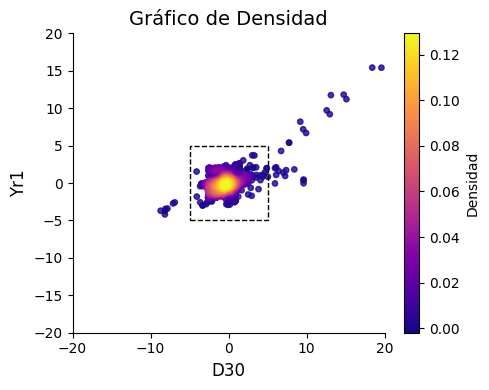

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def density_scatter(x, y, xlab, ylab, ax=None, sort=True, bins=20, cmap='viridis'):
    """
    Scatter plot colored by 2d histogram
    """
    bad_indices = np.where(np.isnan(x))[0].tolist() + np.where(np.isnan(y))[0].tolist()
    x = x[~np.isin(np.arange(x.size), bad_indices)]
    y = y[~np.isin(np.arange(y.size), bad_indices)]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    else:
        fig = ax.figure
        
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x,y]).T, 
                method="splinef2d", bounds_error=False)
    
    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0
    
    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        
    scatter = ax.scatter(x, y, c=z, cmap=cmap, s=15, alpha=0.8)
    
    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.ax.set_ylabel('Densidad')
    
    ax.set_xlabel(xlab, fontsize=12)
    ax.set_ylabel(ylab, fontsize=12)
    ax.set_title('Gráfico de Densidad', fontsize=14)
    
    return ax, fig

# Aplicar la función a result3
# Si necesitas cargar tus datos, descomenta la siguiente línea:
# result3 = pd.read_csv('tu_archivo.csv')  # Reemplaza con la ruta correcta

# Extraer columnas de result3
x = np.array(result3['D30_UB'])
y = np.array(result3['Y1_UB'])

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(5, 4))

# Aplicar la función de densidad scatter
ax, fig = density_scatter(x, y, 'D30', 'Yr1', ax=ax, bins=25, cmap='plasma')

# Añadir el cuadrado de -5 a 5 como en tu código original
ax.add_patch(plt.Rectangle((-5, -5), 10, 10, fill=False, linestyle='--', edgecolor='black'))

# Establecer límites de ejes si es necesario
# Detectar los límites automáticamente basándose en los datos
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
# Añadir un poco de margen
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

# Mejorar la apariencia
plt.tight_layout()

plt.savefig('Chromvar_UB_high_quality.png', dpi=600, bbox_inches='tight', format='png')

# Guardar la figura
plt.show()

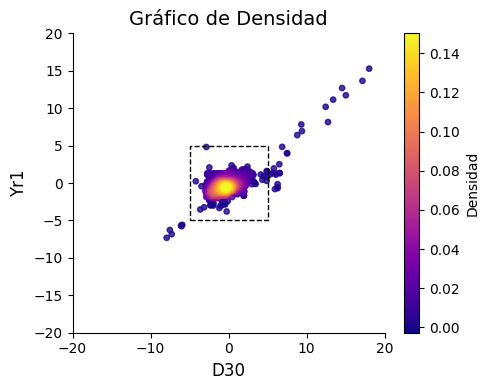

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def density_scatter(x, y, xlab, ylab, ax=None, sort=True, bins=20, cmap='viridis'):
    """
    Scatter plot colored by 2d histogram
    """
    bad_indices = np.where(np.isnan(x))[0].tolist() + np.where(np.isnan(y))[0].tolist()
    x = x[~np.isin(np.arange(x.size), bad_indices)]
    y = y[~np.isin(np.arange(y.size), bad_indices)]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    else:
        fig = ax.figure
        
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x,y]).T, 
                method="splinef2d", bounds_error=False)
    
    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0
    
    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        
    scatter = ax.scatter(x, y, c=z, cmap=cmap, s=15, alpha=0.8)
    
    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.ax.set_ylabel('Densidad')
    
    ax.set_xlabel(xlab, fontsize=12)
    ax.set_ylabel(ylab, fontsize=12)
    ax.set_title('Gráfico de Densidad', fontsize=14)
    
    return ax, fig

# Aplicar la función a result3
# Si necesitas cargar tus datos, descomenta la siguiente línea:
# result3 = pd.read_csv('tu_archivo.csv')  # Reemplaza con la ruta correcta

# Extraer columnas de result3
x = np.array(result3['D30_DB'])
y = np.array(result3['Y1_DB'])

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(5, 4))

# Aplicar la función de densidad scatter
ax, fig = density_scatter(x, y, 'D30', 'Yr1', ax=ax, bins=25, cmap='plasma')

# Añadir el cuadrado de -5 a 5 como en tu código original
ax.add_patch(plt.Rectangle((-5, -5), 10, 10, fill=False, linestyle='--', edgecolor='black'))

# Establecer límites de ejes si es necesario
# Detectar los límites automáticamente basándose en los datos
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
# Añadir un poco de margen
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

# Mejorar la apariencia
plt.tight_layout()

plt.savefig('Chromvar_DB_high_quality.png', dpi=600, bbox_inches='tight', format='png')

# Guardar la figura
plt.show()

In [22]:
result3[result3.index == 'Pit1_I_N1']

condition_celltype,Control_DB_x,Control_UB_x,Control_uHF_x,PIMQ_DB_x,PIMQ_UB_x,PIMQ_uHF_x,celltype_x,X_x,Y_x,Control_DB_y,...,PIMQ_UB_y,PIMQ_uHF_y,celltype_y,X_y,Y_y,D30_UB,Y1_UB,color,D30_DB,Y1_DB
Pit1_I_N1,-1.626047,-2.121426,1.167113,-0.192966,0.351769,4.395866,Pit1_I_N1,2.473195,1.433081,-0.019231,...,-0.633855,3.784430,Pit1_I_N1,0.464413,-0.687704,2.473195,0.464413,blue,1.433081,-0.687704
Pit1_I_N1,-1.626047,-2.121426,1.167113,-0.192966,0.351769,4.395866,Pit1_I_N1,2.473195,1.433081,1.210426,...,-1.249547,4.047225,Pit1_I_N1,-0.030623,-0.544735,2.473195,-0.030623,blue,1.433081,-0.544735
Pit1_I_N1,-1.626047,-2.121426,1.167113,-0.192966,0.351769,4.395866,Pit1_I_N1,2.473195,1.433081,0.932031,...,-0.520657,0.770707,Pit1_I_N1,0.360764,-0.148591,2.473195,0.360764,blue,1.433081,-0.148591
Pit1_I_N1,-3.720693,-6.559113,-0.437071,2.556531,3.047562,7.829220,Pit1_I_N1,9.606674,6.277224,-0.019231,...,-0.633855,3.784430,Pit1_I_N1,0.464413,-0.687704,9.606674,0.464413,blue,6.277224,-0.687704
Pit1_I_N1,-3.720693,-6.559113,-0.437071,2.556531,3.047562,7.829220,Pit1_I_N1,9.606674,6.277224,1.210426,...,-1.249547,4.047225,Pit1_I_N1,-0.030623,-0.544735,9.606674,-0.030623,blue,6.277224,-0.544735
Pit1_I_N1,-3.720693,-6.559113,-0.437071,2.556531,3.047562,7.829220,Pit1_I_N1,9.606674,6.277224,0.932031,...,-0.520657,0.770707,Pit1_I_N1,0.360764,-0.148591,9.606674,0.360764,blue,6.277224,-0.148591
Pit1_I_N1,0.639096,0.008864,0.006124,0.115759,-0.785110,1.614999,Pit1_I_N1,-0.793973,-0.523337,-0.019231,...,-0.633855,3.784430,Pit1_I_N1,0.464413,-0.687704,-0.793973,0.464413,blue,-0.523337,-0.687704
Pit1_I_N1,0.639096,0.008864,0.006124,0.115759,-0.785110,1.614999,Pit1_I_N1,-0.793973,-0.523337,1.210426,...,-1.249547,4.047225,Pit1_I_N1,-0.030623,-0.544735,-0.793973,-0.030623,blue,-0.523337,-0.544735
Pit1_I_N1,0.639096,0.008864,0.006124,0.115759,-0.785110,1.614999,Pit1_I_N1,-0.793973,-0.523337,0.932031,...,-0.520657,0.770707,Pit1_I_N1,0.360764,-0.148591,-0.793973,0.360764,blue,-0.523337,-0.148591


In [26]:
import pandas as pd
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

# Supongamos que result3 es tu DataFrame y 'Y1_UB' contiene los Z-scores
# 1. Calcular p-values de dos colas a partir de Z-scores
result3['pval'] = 2 * norm.sf(np.abs(result3['Y1_UB']))

# 2. Ajustar los p-values usando el método de Benjamini-Hochberg (FDR)
rejected, pvals_corrected, _, _ = multipletests(result3['pval'], method='bonferroni')

# 3. Guardar los p-adjusted en una nueva columna
result3['pval_adj'] = pvals_corrected

# Opcional: también puedes guardar qué tests son significativos tras ajuste
result3['significant'] = rejected

In [27]:
result3[result3['Y1_UB'] < 5][['Y1_UB', 'pval', 'pval_adj']].sort_values('Y1_UB')

condition_celltype,Y1_UB,pval,pval_adj
Gata2_I,-4.191114,0.000028,0.039695
Gata4_D_N1,-3.739715,0.000184,0.263448
Gata1_D,-3.701334,0.000214,0.306690
Gata5_D,-3.448854,0.000563,0.805048
Gata3_D,-3.410902,0.000647,0.925902
...,...,...,...
Rel_I,2.644806,0.008174,1.000000
Cic_D,3.028950,0.002454,1.000000
Nfkb1_I,3.681202,0.000232,0.331956
Rela_D_N1,3.705281,0.000211,0.301954


## Now for DB

In [17]:
result3['D30_DB'] = result3['PIMQ_DB_x'] - result3['Control_DB_x']
result3['Y1_DB'] = result3['PIMQ_DB_y'] - result3['Control_DB_y']

In [18]:
import plotly.express as px
import plotly.graph_objects as go

# Asignar color según condición
result3['color'] = ['red' if celltype in ['Jun_D', 'Gata3_D', 'Fos_I', 'Stat3_D'] else 'blue' 
                    for celltype in result3['celltype_x']]

# Crear el scatter plot
fig = px.scatter(result3, x="D30_DB", y="Y1_DB", 
                 color='color',
                 hover_name="celltype_x", 
                 labels={"D30_DB": "D30", "Y1_DB": "Yr1"},
                 hover_data=['celltype_x',"D30_DB", "Y1_DB"])

# Estilo de los puntos
fig.update_traces(marker=dict(size=8), selector=dict(mode='markers'))

# Limitar ejes
fig.update_layout(
    xaxis=dict(range=[-20, 20]),
    yaxis=dict(range=[-20, 20]),
    legend_title_text='Celltype',
    legend=dict(itemsizing='constant', itemwidth=30)
)

# Agregar cuadrado de -5 a 5
fig.add_shape(
    type="rect",
    x0=-5, y0=-5, x1=5, y1=5,
    line=dict(color="black", width=2, dash="dash"),
    fillcolor="rgba(0,0,0,0)"
)

# Cambiar nombre de la leyenda si deseas
fig.data[0].name = 'All TFs'
fig.data[1].name = 'Highlighted'

# Guardar como HTML interactivo
fig.write_html("scatter_plot_together_DB.html")
print("Archivo guardado como scatter_plot_together.html")


Archivo guardado como scatter_plot_together.html


# Functions and files

In [2]:
def procesar_strings(lista_strings):
    resultado = []
    for s in lista_strings:
        partes = s.split('_')
        if len(partes) >= 5:
            resultado.append('_'.join(partes[-3:]))
        elif len(partes) == 4:
            resultado.append('_'.join(partes[-2:]))
        else:
            resultado.append(s)  # Si no tiene 4 o 5 elementos, lo dejamos igual
    return resultado
ad_norm_obs = pd.read_csv("../intermediate_outputs3/DESeq2_files/metadata_scpeakset_D30.tsv", sep = '\t')


## Lectura para all-memory

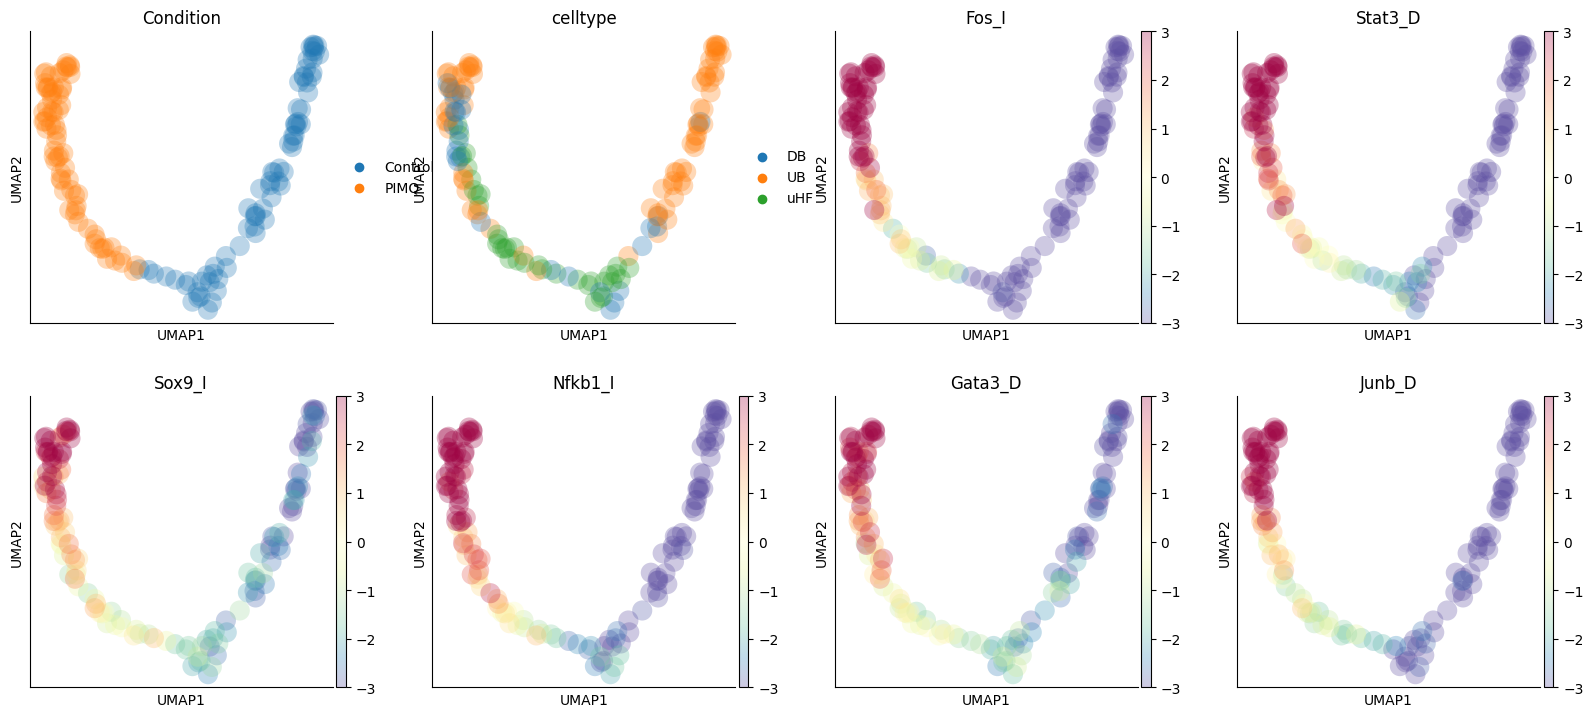

Archivo guardado como scatter_plot.html


In [36]:
bName = 'D30_M12_memory'
devScores = pd.read_csv("../intermediate_outputs3/chromvar/" + bName + "_deviationScores.csv", index_col = 0)
ad = sc.AnnData(devScores.T)
ad.obs_names = ad.obs_names.astype(str)

ad.var_names = procesar_strings(list(ad.var_names))
ad.obs = ad_norm_obs
ad = ad[:, ~np.isnan(ad.X).any(axis=0)]
sc.pp.pca(ad, n_comps = 50)
sc.pp.neighbors(ad, n_neighbors = 5)
sc.tl.umap(ad, n_components = 50)
sc.pl.umap(ad, color = ['Condition', 'celltype', 'Fos_I', 'Stat3_D', 'Sox9_I', 'Nfkb1_I', 'Gata3_D', 'Junb_D'], alpha = 0.3, vmax = 3, vmin = -3)
score_df = ad.to_df().copy()
score_df['condition_celltype'] = ad.obs['condition_celltype']

result = score_df.groupby('condition_celltype').mean().T
result['celltype'] = result.index
result['X'] = result['PIMQ_UB'] - result['Control_UB']
result['Y'] = result['PIMQ_DB'] - result['Control_DB']

result[result['celltype'].str.contains('Fos')]
import plotly.express as px

result['color'] = ['red' if celltype in ['Junb_D', 'Gata3_D', 'Fosb_I', 'Stat3_D'] else 'blue' for celltype in result['celltype']]

fig = px.scatter(result, x="X", y="Y", 
                 color='color',
                 hover_name="celltype", 
                 labels={"X": "Diff (PIMQ_UB - Control_UB)", "Y": "Diff (PIMQ_DB - Control_DB)"},
                 hover_data=['celltype',"Control_UB", "PIMQ_UB", 'Control_DB', 'PIMQ_DB'])

fig.update_traces(marker=dict(size=8),
                  selector=dict(mode='markers'))

fig.update_layout(
    legend_title_text='Celltype',
    legend=dict(
        itemsizing='constant',
        itemwidth=30
    )
)

fig.data[0].name = 'All TFs'
fig.data[1].name = 'Highlighted TFs'

# Guardar como HTML interactivo
fig.write_html(bName + "_scatter_plot.html")

print("Archivo guardado como scatter_plot.html")


In [32]:
bName = 'unchanged_downsampled'
devScores = pd.read_csv("../intermediate_outputs3/chromvar/" + bName + "_deviationScores.csv", index_col = 0)
ad = sc.AnnData(devScores.T)
ad.obs_names = ad.obs_names.astype(str)

ad.var_names = procesar_strings(list(ad.var_names))
ad.obs = ad_norm_obs

In [28]:
import numpy as np

# Eliminar filas (células) con NaN en la matriz X
ad = ad[~np.isnan(ad.X).any(axis=1), :]

# Eliminar columnas (genes) con NaN en la matriz X
#ad = ad[:, ~np.isnan(ad.X).any(axis=0)]



In [34]:
ad.to_df()

,Tcfap2a_D_N1,Tcfap2b_D,Tcfap2c_D,Tcfap2e_D,Tcfap2d_I,Arid3b_D,Arid3a_D_N3,Arid5b_D,Arid5a_D,Arid3c_I,...,Zfp42_I_N14,Zfp263_I_N2,Zfp263_I_N1,Zfp263_I_N1,Dmrta2_I_N3,Foxm1_I_N1,Mixl1_I,Mef2b_I_N14,Smad5_I_N1,Smad9_I_N1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Lectura para short-term memory

## Lectura para resolved

## Lecutra para unchanged